In [2]:
import pandas as pd
import os
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import matplotlib.pyplot as plt
import sys
from sklearn.preprocessing import LabelEncoder
import glob
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.metrics import classification_report

In [3]:
subjects = pd.read_csv('/kaggle/input/sisfall-multiclass-data/Subjects.csv')
activity = pd.read_csv('/kaggle/input/sisfall-multiclass-data/Activities.csv')


In [4]:

trial_dict = {}
for _s in subjects.ID:
    for _a in activity.ID:
        dpath = os.path.abspath(os.path.join('/kaggle/input/sis-fall-original-dataset/SisFall_dataset',_s))
        fpath = os.path.join(dpath,_a)
        files = glob.glob("%s*.txt" % fpath)
        trial_dict[_s,_a] = []
        for _f in files:
            _t = os.path.split(_f)[-1].split('_')[-1].split('.')[0]
            trial_dict[_s,_a].append(_t)
        trial_dict[_s,_a].sort()
        #print(_s, _a, "has", len(trial_dict[_s,_a]), "trials")

1292 entries
4505 trials
0 entries without trials


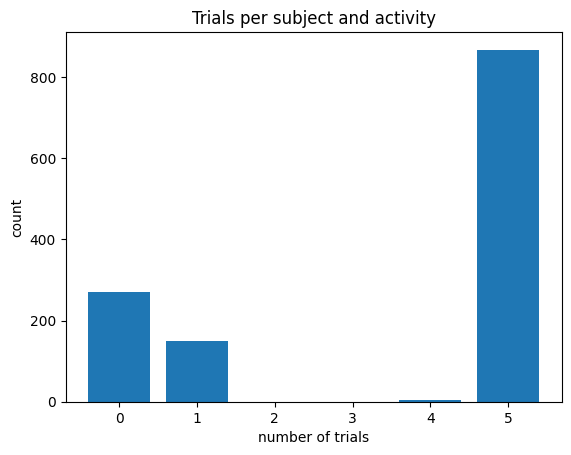

In [5]:
total = 0
notrial = 0
n_trials = [[], []]
for key in trial_dict.keys():
    _nt = len(trial_dict[key])
    total += _nt
    n_trials[0].append(_nt)
    if n_trials == 0:
        notrial += 1
print(len(trial_dict.keys()), "entries")
print(total, "trials")
print(notrial, "entries without trials")

n_trials = (n_trials)
plt.hist(n_trials[0], bins=[-0.5,0.5,1.5,2.5,3.5,4.5,5.5], 
         rwidth = 0.8, align='mid')
plt.title("Trials per subject and activity")
plt.xlabel("number of trials")
plt.ylabel("count")
plt.show()

In [6]:
trial_dict[list(trial_dict.keys())[10]]

['R01', 'R02', 'R03', 'R04', 'R05']

In [7]:
def fpath(sub,act,trial):
    _fn = "%s_%s_%s.txt" % (act,sub,trial)
    _fp = os.path.abspath(os.path.join('/kaggle/input/sis-fall-original-dataset/SisFall_dataset',sub))
    _fp = os.path.join(_fp,_fn)
    return _fp

In [8]:
sub, act = list(trial_dict.keys())[20]
trial = trial_dict[sub,act][-1]
print(fpath(sub,act,trial))

/kaggle/input/sis-fall-original-dataset/SisFall_dataset/SA01/F02_SA01_R05.txt


In [9]:
def age_of_subject(subject_id):
    return int(subjects[subjects.ID == subject_id].Age)

def activity_str(activity_id):
#    return activity.loc[activity.ID == activity_id]['Activity'].values[0]
    return activity_id
print("Subject age %i" % age_of_subject(sub))
print("  %s" % activity_str(act))

Subject age 26
  F02


In [10]:
class Trial:
    
    def __init__(self, fname, age, action, trial_id,
                 fps = 200,
                 features = ["ax","ay","az",
                             "rx","ry","rz",
                             "ax2","ay2","az2"]):
        self.fname = fname
        self.df = pd.read_csv(fname, header=None)
        self.df.columns = features
        self.fps = fps
        self.age = age
        self.action = action
        self.id = trial_id
        self.fall = False
        if action[0] == 'F':
            self.fall = True
        
    def print_info(self):
        print("  Trial Info")
        print("         age:", self.age)
        print("      action:", self.action)
        print("          ID:", self.id)
        print("         fps:", self.fps)
        print("       steps:", len(self.df))
        print("     time(s):", len(self.df)/self.fps)
        print("        file:", self.fname)
       
        #print("    features:", list(self.df.columns))
        print("\n")
        
    def plot(self, cols, title = None):
        for col in cols:
            plt.plot(self.df.index/self.fps, self.df[col], 
                     label = col)
            plt.xlabel("time (sec)")
            plt.ylabel("signal")
            plt.legend()
            plt.title(title)
        plt.show()
        plt.clf()
        
    def hist(self, cols, title = None):
        for col in cols:
            plt.hist(self.df[col], bins = 40, 
                     alpha = 0.5, label = col)
            plt.xlabel("signal")
            plt.ylabel("freq.")
            plt.legend()
            plt.title(title)
        plt.show()
        plt.clf()
        
    def get_features(self,cols):
        return self.df[cols].values, self.action

  Trial Info
         age: 26
      action: D19
          ID: R01
         fps: 200
       steps: 2400
     time(s): 12.0
        file: /kaggle/input/sis-fall-original-dataset/SisFall_dataset/SA01/D19_SA01_R01.txt




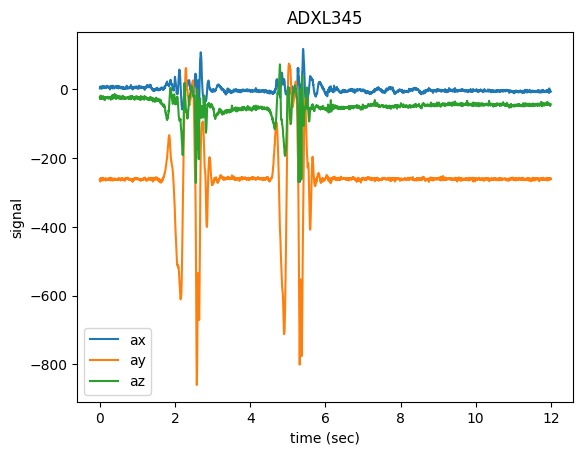

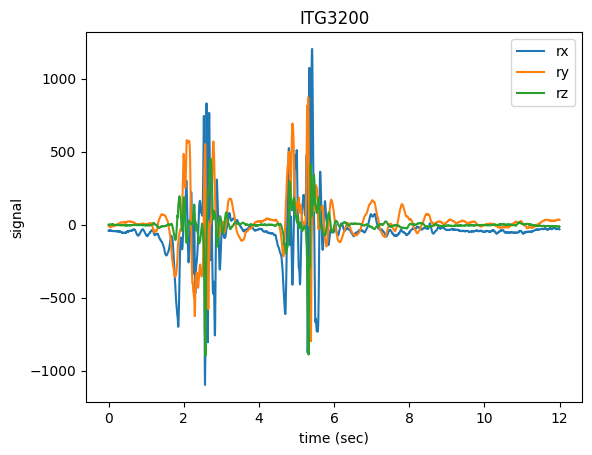

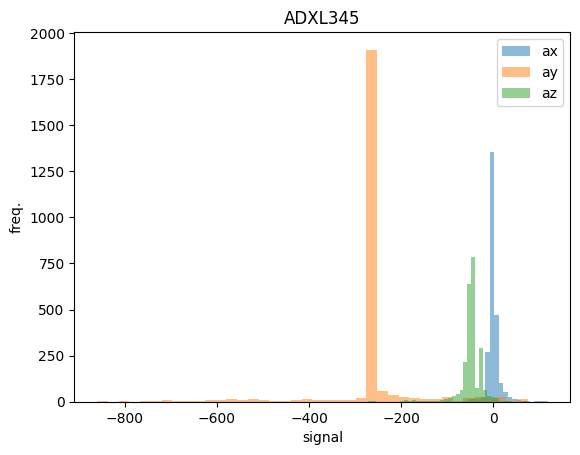

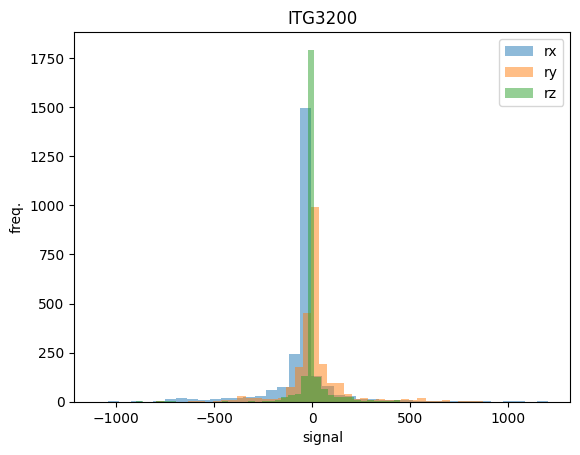

(array([[-42,  -8,  -1],
        [-42,  -9,  -1],
        [-43,  -9,   0],
        ...,
        [-31,  34, -15],
        [-31,  33, -13],
        [-32,  33, -14]]),
 'D19')

<Figure size 640x480 with 0 Axes>

In [11]:
_subject = 'SA01'
_activity = 'D19'
_tnum = 'R01'

_trial = Trial( fpath(_subject,_activity,_tnum), 
                age_of_subject(_subject),
                activity_str(_activity), _tnum )
_trial.print_info()

trace = { 'ADXL345':  ['ax','ay','az'],
           'ITG3200':  ['rx','ry','rz'],
           'MMA8451Q': ['ax2','ay2','az2'] }

for sensor in list(trace.keys())[:-1]:
    _trial.plot(trace[sensor], sensor)

for sensor in list(trace.keys())[:-1]:
    _trial.hist(trace[sensor], sensor)
    
_trial.get_features(trace['ITG3200'])

  Trial Info
         age: 26
      action: F07
          ID: R01
         fps: 200
       steps: 3000
     time(s): 15.0
        file: /kaggle/input/sis-fall-original-dataset/SisFall_dataset/SA01/F07_SA01_R01.txt




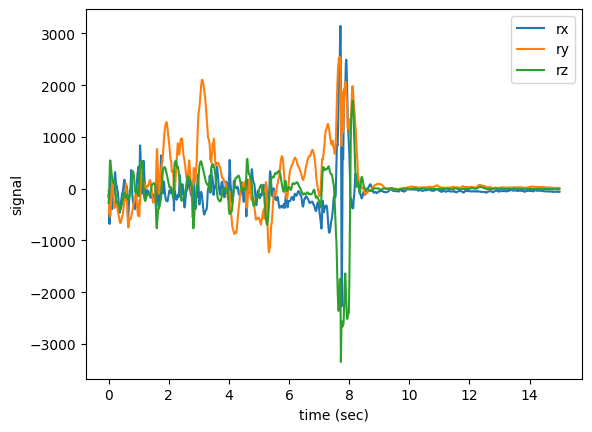

<Figure size 640x480 with 0 Axes>

In [12]:
sens = 'ITG3200'
_activity = 'F07'
_trial = Trial( fpath(_subject,_activity,_tnum), 
                age_of_subject(_subject),
                activity_str(_activity), _tnum )
_trial.print_info()

_trial.plot(trace[sens])

In [13]:
sensors = ['ITG3200' ]
data_set = []
for _s in subjects.ID[subjects.ID.str.contains(r'SE', na=True)]:
    for _a in activity.ID:
        for _t in trial_dict[_s,_a]:
            try:
                _trial = Trial(fpath(_s,_a,_t),
                               age_of_subject(_s),
                               activity_str(_a), _t)
                #_trial.print_info()
                for sensor in sensors:
                    _ftr = _trial.get_features(trace[sensor])
                    if len(_ftr[0]) > 0:
                        data_set.append(_ftr)
            except FileNotFoundError:
                print("No file found for",_s,_a,_t)
data_set = data_set

In [14]:
#np.random.shuffle(data_set)
_ds = []
_ls = []
for entry in data_set:
    if len(entry[0]) >= 2400:
        _ds.append(entry[0][0:2400])
        _ls.append(entry[1])
signals = np.array(_ds)
labels = np.array(_ls)

In [15]:
sensors = ['ADXL345' ]
data_set2 = []
for _s in subjects.ID[subjects.ID.str.contains(r'SE', na=True)]:
    for _a in activity.ID:
        for _t in trial_dict[_s,_a]:
            try:
                _trial = Trial(fpath(_s,_a,_t),
                               age_of_subject(_s),
                               activity_str(_a), _t)
                #_trial.print_info()
                for sensor in sensors:
                    _ftr = _trial.get_features(trace[sensor])
                    if len(_ftr[0]) > 0:
                        data_set2.append((_ftr))
            except FileNotFoundError:
                print("No file found for",_s,_a,_t)
data_set2 = (data_set2)

In [16]:
#np.random.shuffle(data_set)
_ds = []
_ls = []
for entry in data_set2:
    if len(entry[0]) >= 2400:
        _ds.append(entry[0][0:2400])
        _ls.append(entry[1])
signals2 = np.array(_ds)
labels2 = np.array(_ls)

In [17]:
signals = np.concatenate((signals, signals2), axis=2)
signals.shape,labels.shape

((908, 2400, 6), (908,))

In [18]:
sensors = ['MMA8451Q' ]
data_set = []
for _s in subjects.ID[subjects.ID.str.contains(r'SE', na=True)]:
    for _a in activity.ID:
        for _t in trial_dict[_s,_a]:
            try:
                _trial = Trial(fpath(_s,_a,_t),
                               age_of_subject(_s),
                               activity_str(_a), _t)
                #_trial.print_info()
                for sensor in sensors:
                    _ftr = _trial.get_features(trace[sensor])
                    if len(_ftr[0]) > 0:
                        data_set.append(_ftr)
            except FileNotFoundError:
                print("No file found for",_s,_a,_t)
data_set = data_set



In [19]:
#int_value = int(str_value.rstrip(';'))
len(data_set[0][0])
for j in range(len(data_set)):
    for i in range(len(data_set[j][0])):
        data_set[j][0][i][2] = int(data_set[j][0][i][2].rstrip(';'))
    


In [20]:
#np.random.shuffle(data_set)
_ds = []
_ls = []
for entry in data_set:
    if len(entry[0]) >= 2400:
        _ds.append(entry[0][0:2400])
        _ls.append(entry[1])
signals1 = np.array(_ds)
labels1 = np.array(_ls)

In [21]:
signals1 = signals1.astype(np.float32)
#signals1 = np.linalg.norm(signals1, axis=-1) - 1
signals1.shape, labels1.shape

((908, 2400, 3), (908,))

In [22]:
sensors = ['ADXL345' ]
data_set2 = []
for _s in subjects.ID[subjects.ID.str.contains(r'SE', na=True)]:
    for _a in activity.ID:
        for _t in trial_dict[_s,_a]:
            try:
                _trial = Trial(fpath(_s,_a,_t),
                               age_of_subject(_s),
                               activity_str(_a), _t)
                #_trial.print_info()
                for sensor in sensors:
                    _ftr = _trial.get_features(trace[sensor])
                    if len(_ftr[0]) > 0:
                        data_set2.append((_ftr))
            except FileNotFoundError:
                print("No file found for",_s,_a,_t)
data_set2 = (data_set2)

In [23]:
#np.random.shuffle(data_set)
_ds = []
_ls = []
for entry in data_set2:
    if len(entry[0]) >= 2400:
        _ds.append(entry[0][0:2400])
        _ls.append(entry[1])
signals2 = np.array(_ds)
labels2 = np.array(_ls)

In [24]:
signals.shape,signals1.shape

((908, 2400, 6), (908, 2400, 3))

In [25]:
signals1 = np.concatenate((signals1, signals2), axis=2)
signals.shape,labels.shape,signals1.shape, labels1.shape
signals = np.concatenate((signals, signals1), axis=0)
labels = np.concatenate((labels,labels1), axis=0)
signals.shape, labels.shape

((1816, 2400, 6), (1816,))

In [26]:
# Assuming your labels array is named 'labels'
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)
# signals2 = signals2.astype(np.float32)
signals.shape, encoded_labels.shape

((1816, 2400, 6), (1816,))

In [27]:
signal,label = signals, encoded_labels

In [28]:
unique_labels = np.unique(label)
print("Unique Labels:", unique_labels)

Unique Labels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33]


In [29]:
error

NameError: name 'error' is not defined

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np

# Define the Generator
def build_generator(latent_dim, output_shape):
    model = models.Sequential()
    model.add(layers.Dense(np.prod(output_shape), input_dim=latent_dim))
    model.add(layers.Reshape(output_shape))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.LeakyReLU(alpha=0.2))
    return model

# Define the Discriminator
def build_discriminator(input_shape):
    model = models.Sequential()
    model.add(layers.Flatten(input_shape=input_shape))
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

# Define the GAN
def build_gan(generator, discriminator):
    discriminator.trainable = False
    model = models.Sequential()
    model.add(generator)
    model.add(discriminator)
    return model

# Compile the Discriminator
def compile_discriminator(discriminator):
    discriminator.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Compile the GAN
def compile_gan(gan):
    gan.compile(loss='binary_crossentropy', optimizer='adam')

# Train the GAN
def train_gan(generator, discriminator, gan, signals, labels):
    epochs = 700
    batch_size = 32
    half_batch = batch_size // 2
    signal_shape = signals.shape[1:]
    augmented_data = []

    for epoch in range(epochs):
        # Select a random half batch of real data
        idx = np.random.randint(0, signals.shape[0], half_batch)
        real_signals = signals[idx]
        real_labels = labels[idx]

        # Generate a half batch of fake samples
        noise = np.random.normal(0, 1, (half_batch, 100))
        fake_signals = generator.predict(noise)
        fake_labels = np.zeros((half_batch,))

        # Train the discriminator
        d_loss_real = discriminator.train_on_batch(real_signals, real_labels)
        d_loss_fake = discriminator.train_on_batch(fake_signals, fake_labels)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Generate noise for the generator
        noise = np.random.normal(0, 1, (batch_size, 100))

        # Labels for the generator
        valid_labels = np.ones((batch_size,))

        # Train the generator
        g_loss = gan.train_on_batch(noise, valid_labels)
        
        # Combine real and fake signals for training your model
        augmented_signals = np.concatenate([real_signals, fake_signals])
        augmented_labels = np.concatenate([real_labels, fake_labels])

        augmented_data.append((augmented_signals, augmented_labels))

        # Print progress
        if epoch % 100 == 0:
            print(f"Epoch {epoch}, D Loss: {d_loss[0]}, G Loss: {g_loss}")
        
    return augmented_data

# Example usage
latent_dim = 100
output_shape = signals.shape[1:]
generator = build_generator(latent_dim, output_shape)
discriminator = build_discriminator(output_shape)
gan = build_gan(generator, discriminator)

compile_discriminator(discriminator)
compile_gan(gan)

augmented_data = train_gan(generator, discriminator, gan, signals, encoded_labels)


In [ ]:
augmented_signals = np.concatenate([item[0] for item in augmented_data])
augmented_labels = np.concatenate([item[1] for item in augmented_data])
augmented_signals.shape, augmented_labels.shape

In [ ]:
from sklearn.model_selection import train_test_split

# Assuming 'signals' contains the signal data and 'encoded_labels' are the numerical labels
X_train, X_test, y_train, y_test = train_test_split(augmented_signals, augmented_labels, test_size=0.2, random_state=42)

from tensorflow.keras import models, layers

model = models.Sequential()

# Convolutional layers
model.add(layers.Conv1D(64, kernel_size=3, activation='relu', input_shape=(2400,6)))
model.add(layers.MaxPooling1D(pool_size=2))
model.add(layers.Conv1D(128, kernel_size=3, activation='relu'))
model.add(layers.MaxPooling1D(pool_size=2))
model.add(layers.Conv1D(256, kernel_size=3, activation='relu'))
model.add(layers.MaxPooling1D(pool_size=2))

# Flatten layer to transition from convolutional layers to dense layers
model.add(layers.Flatten())

# Dense layers
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(units=34, activation='softmax'))  # Output layer

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test))

test_loss, test_acc = model.evaluate(signals, encoded_labels)

import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Making predictions
y_pred = model.predict(signals)

# Converting predictions to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculating precision, recall, and F1 score
precision = precision_score(encoded_labels, y_pred_classes, average='weighted')
recall = recall_score(encoded_labels, y_pred_classes, average='weighted')
f1 = f1_score(encoded_labels, y_pred_classes, average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Calculating ROC curve and AUC
n_classes = 34  # Number of classes
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(encoded_labels == i, y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotting ROC curve
plt.figure(figsize=(10, 8))
plt.plot([0, 1], [0, 1], 'k--')
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='Class {} (AUC = {:.2f})'.format(i, roc_auc[i]))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
signals.shape, encoded_labels.shape

import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt

# Define the Generator
def build_generator(latent_dim, output_shape):
    model = models.Sequential()
    model.add(layers.Dense(256, input_dim=latent_dim))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dense(512))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dense(1024))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dense(np.prod(output_shape), activation='tanh'))
    model.add(layers.Reshape(output_shape))
    return model

# Define the Discriminator
def build_discriminator(input_shape):
    model = models.Sequential()
    model.add(layers.Flatten(input_shape=input_shape))
    model.add(layers.Dense(512))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dense(256))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

# Define the GAN
def build_gan(generator, discriminator):
    discriminator.trainable = False
    model = models.Sequential()
    model.add(generator)
    model.add(discriminator)
    return model

# Compile the Discriminator
def compile_discriminator(discriminator):
    discriminator.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Compile the GAN
def compile_gan(gan):
    gan.compile(loss='binary_crossentropy', optimizer='adam')

# Train the GAN with loss monitoring
def train_gan(generator, discriminator, gan, signals, labels):
    epochs = 800
    batch_size = 16
    half_batch = batch_size // 2
    signal_shape = signals.shape[1:]
    augmented_data = []

    # Lists to store loss values for plotting
    d_losses = []
    g_losses = []

    for epoch in range(epochs):
        # Select a random half batch of real data
        idx = np.random.randint(0, signals.shape[0], half_batch)
        real_signals = signals[idx]
        real_labels = labels[idx]

        # Generate a half batch of fake samples
        noise = np.random.normal(0, 1, (half_batch, 100))
        fake_signals = generator.predict(noise)
        fake_labels = np.zeros((half_batch,))

        # Train the discriminator
        d_loss_real = discriminator.train_on_batch(real_signals, real_labels)
        d_loss_fake = discriminator.train_on_batch(fake_signals, fake_labels)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Generate noise for the generator
        noise = np.random.normal(0, 1, (batch_size, 100))

        # Labels for the generator
        valid_labels = np.ones((batch_size,))

        # Train the generator
        g_loss = gan.train_on_batch(noise, valid_labels)
        
        # Store losses for plotting
        d_losses.append(d_loss[0])
        g_losses.append(g_loss)
        
        # Print progress
        if epoch % 30 == 0:
            print(f"Epoch {epoch}, D Loss: {d_loss[0]}, G Loss: {g_loss}")
        
    # Plot the loss curves
    plt.figure(figsize=(12, 6))
    plt.plot(range(epochs), d_losses, label='Discriminator Loss')
    plt.plot(range(epochs), g_losses, label='Generator Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('GAN Training Loss')
    plt.legend()
    plt.show()

    return augmented_data



latent_dim = 100
output_shape = signals.shape[1:]
generator = build_generator(latent_dim, output_shape)
discriminator = build_discriminator(output_shape)
gan = build_gan(generator, discriminator)

compile_discriminator(discriminator)
compile_gan(gan)

augmented_data = train_gan(generator, discriminator, gan, signals, encoded_labels)



import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np

# Define the Generator
def build_generator(latent_dim, output_shape):
    model = models.Sequential()
    model.add(layers.Dense(np.prod(output_shape), input_dim=latent_dim))
    model.add(layers.Reshape(output_shape))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.LeakyReLU(alpha=0.2))
    return model

# Define the Discriminator
def build_discriminator(input_shape):
    model = models.Sequential()
    model.add(layers.Flatten(input_shape=input_shape))
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

# Define the GAN
def build_gan(generator, discriminator):
    discriminator.trainable = False
    model = models.Sequential()
    model.add(generator)
    model.add(discriminator)
    return model

# Compile the Discriminator
def compile_discriminator(discriminator):
    discriminator.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Compile the GAN
def compile_gan(gan):
    gan.compile(loss='binary_crossentropy', optimizer='adam')

# Train the GAN
def train_gan(generator, discriminator, gan, signals, labels):
    epochs = 100
    batch_size = 32
    half_batch = batch_size // 2
    signal_shape = signals.shape[1:]
    augmented_data = []

    for epoch in range(epochs):
        # Select a random half batch of real data
        idx = np.random.randint(0, signals.shape[0], half_batch)
        real_signals = signals[idx]
        real_labels = labels[idx]

        # Generate a half batch of fake samples
        noise = np.random.normal(0, 1, (half_batch, 100))
        fake_signals = generator.predict(noise)
        fake_labels = np.zeros((half_batch,))

        # Train the discriminator
        d_loss_real = discriminator.train_on_batch(real_signals, real_labels)
        d_loss_fake = discriminator.train_on_batch(fake_signals, fake_labels)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Generate noise for the generator
        noise = np.random.normal(0, 1, (batch_size, 100))

        # Labels for the generator
        valid_labels = np.ones((batch_size,))

        # Train the generator
        g_loss = gan.train_on_batch(noise, valid_labels)
        
        # Combine real and fake signals for training your model
        augmented_signals = np.concatenate([real_signals, fake_signals])
        augmented_labels = np.concatenate([real_labels, fake_labels])

        augmented_data.append((augmented_signals, augmented_labels))

        # Print progress
        if epoch % 100 == 0:
            print(f"Epoch {epoch}, D Loss: {d_loss[0]}, G Loss: {g_loss}")
        
    return augmented_data

# Example usage
latent_dim = 100
output_shape = signals.shape[1:]
generator = build_generator(latent_dim, output_shape)
discriminator = build_discriminator(output_shape)
gan = build_gan(generator, discriminator)

compile_discriminator(discriminator)
compile_gan(gan)

augmented_data = train_gan(generator, discriminator, gan, signals, encoded_labels)

2024-04-10 07:14:45.539380: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-10 07:14:45.539489: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-10 07:14:45.668734: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 910ms/step


I0000 00:00:1712733293.766086   11365 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1712733294.263443   11367 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712733294.525505   11366 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Epoch 0, D Loss: 46.56919860839844, G Loss: 12.110219955444336
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Epoch 10, D Loss: -9.87455940246582, G Loss: 8.050432205200195
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Epoch 20, D Loss: -10.761353492736816, G Loss: 7.658192157745361
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━

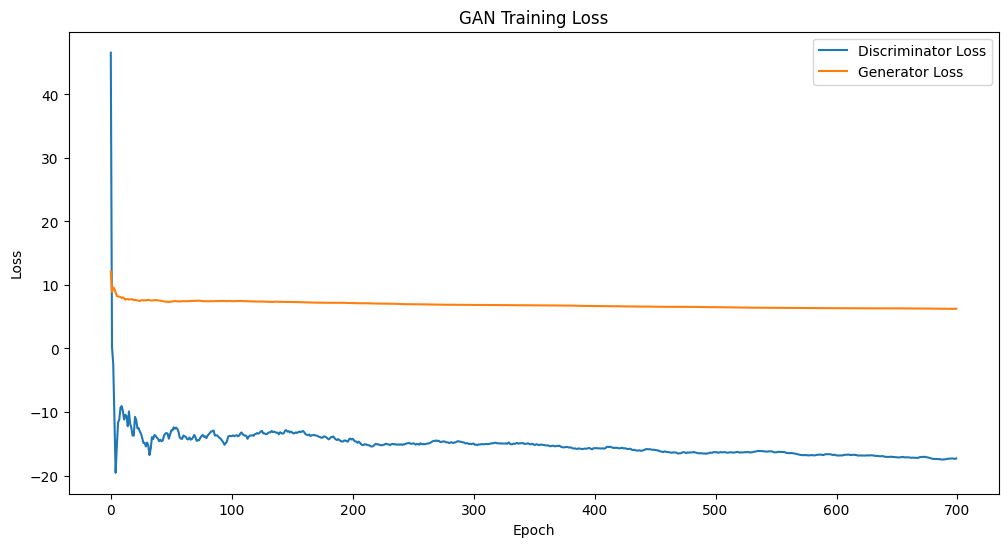

In [30]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np


# Define the Generator
def build_generator(latent_dim, output_shape):
    model = models.Sequential()
    model.add(layers.Dense(np.prod(output_shape), input_dim=latent_dim))
    model.add(layers.Reshape(output_shape))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.LeakyReLU(alpha=0.2))
    return model

# Define the Discriminator



from tensorflow.keras import layers, models
import tensorflow.keras.backend as K

def build_discriminator(input_shape):
    model = models.Sequential()
    model.add(layers.Flatten(input_shape=input_shape))
    model.add(layers.Dense(128))  # Increase the number of units for more complexity
    model.add(layers.LeakyReLU(alpha=0.2))  # Leaky ReLU activation
    model.add(layers.Dense(1))  # Output layer (no activation needed for discriminator)
    return model


# Define the GAN
def build_gan(generator, discriminator):
    discriminator.trainable = False
    model = models.Sequential()
    model.add(generator)
    model.add(discriminator)
    return model

# Compile the Discriminator
def compile_discriminator(discriminator):
    discriminator.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Compile the GAN
def compile_gan(gan):
    gan.compile(loss='binary_crossentropy', optimizer='adam')

# Train the GAN
# Train the GAN
def train_gan(generator, discriminator, gan, signals, labels):
    epochs = 700
    batch_size = 32
    half_batch = batch_size // 2
    signal_shape = signals.shape[1:]
    augmented_data = []
    # Lists to store loss values for plotting
    d_losses = []
    g_losses = []
    
    for epoch in range(epochs):
        # Select a random half batch of real data
        idx = np.random.randint(0, signals.shape[0], half_batch)
        real_signals = signals[idx]
        real_labels = labels[idx]

        # Generate a half batch of fake samples
        noise = np.random.normal(0, 1, (half_batch, 100))
        fake_signals = generator.predict(noise)
        fake_labels = np.zeros((half_batch,))

        # Train the discriminator
        d_loss_real = discriminator.train_on_batch(real_signals, real_labels)
        d_loss_fake = discriminator.train_on_batch(fake_signals, fake_labels)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Generate noise for the generator
        noise = np.random.normal(0, 1, (batch_size, 100))

        # Labels for the generator
        valid_labels = np.ones((batch_size,))

        # Train the generator
        g_loss = gan.train_on_batch(noise, valid_labels)
        
        # Store losses for plotting
        d_losses.append(d_loss[0])
        g_losses.append(g_loss)
        
        # Combine real and fake signals for training your model
        augmented_signals = np.concatenate([real_signals, fake_signals])
        augmented_labels = np.concatenate([real_labels, fake_labels])

        augmented_data.append((augmented_signals, augmented_labels))

        # Print progress
        if epoch % 10 == 0:
            print(f"Epoch {epoch}, D Loss: {d_loss[0]}, G Loss: {g_loss}")
        
    

    # Plot the loss curves
    plt.figure(figsize=(12, 6))
    plt.plot(range(epochs), d_losses, label='Discriminator Loss')
    plt.plot(range(epochs), g_losses, label='Generator Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('GAN Training Loss')
    plt.legend()
    plt.show()

    return augmented_data

# Example usage
latent_dim = 100
output_shape = signals.shape[1:]
generator = build_generator(latent_dim, output_shape)
discriminator = build_discriminator(output_shape)
gan = build_gan(generator, discriminator)

compile_discriminator(discriminator)
compile_gan(gan)

augmented_data = train_gan(generator, discriminator, gan, signals, encoded_labels)

In [31]:
augmented_signals = np.concatenate([item[0] for item in augmented_data])
augmented_labels = np.concatenate([item[1] for item in augmented_data])
augmented_signals.shape, augmented_labels.shape

((22400, 2400, 6), (22400,))

Epoch 1/50
1120/1120 ━━━━━━━━━━━━━━━━━━━━ 25s 15ms/step - accuracy: 0.7823 - loss: 0.9237 - val_accuracy: 0.9507 - val_loss: 0.1841
Epoch 2/50
1120/1120 ━━━━━━━━━━━━━━━━━━━━ 16s 14ms/step - accuracy: 0.9556 - loss: 0.1729 - val_accuracy: 0.9862 - val_loss: 0.0974
Epoch 3/50
1120/1120 ━━━━━━━━━━━━━━━━━━━━ 16s 14ms/step - accuracy: 0.9757 - loss: 0.1021 - val_accuracy: 0.9908 - val_loss: 0.0555
Epoch 4/50
1120/1120 ━━━━━━━━━━━━━━━━━━━━ 16s 14ms/step - accuracy: 0.9867 - loss: 0.0569 - val_accuracy: 0.9960 - val_loss: 0.0217
Epoch 5/50
1120/1120 ━━━━━━━━━━━━━━━━━━━━ 16s 14ms/step - accuracy: 0.9859 - loss: 0.0570 - val_accuracy: 0.9971 - val_loss: 0.0186
Epoch 6/50
1120/1120 ━━━━━━━━━━━━━━━━━━━━ 16s 14ms/step - accuracy: 0.9929 - loss: 0.0372 - val_accuracy: 0.9982 - val_loss: 0.0135
Epoch 7/50
1120/1120 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - accuracy: 0.9887 - loss: 0.0432 - val_accuracy: 0.9984 - val_loss: 0.0185
Epoch 8/50
1120/1120 ━━━━━━━━━━━━━━━━━━━━ 16s 14ms/step - accuracy: 0.9929 -

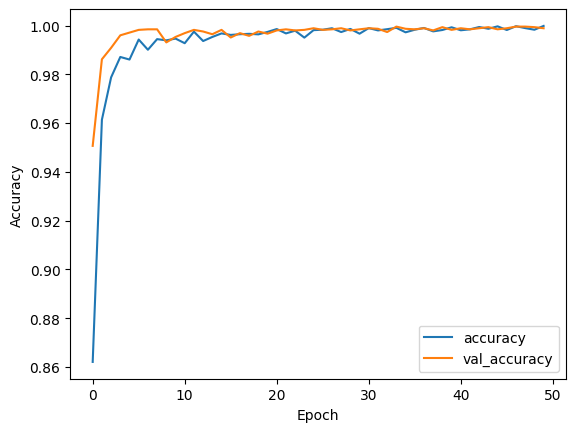

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
Precision: 0.9984019830889266
Recall: 0.9983480176211453
F1 Score: 0.9983602667409884


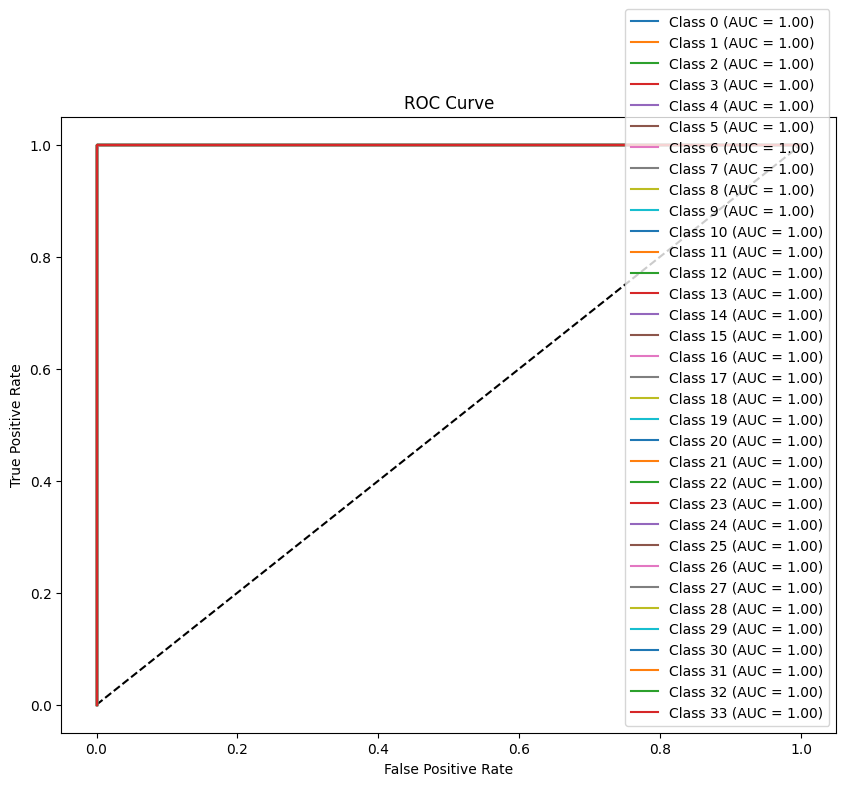

In [33]:
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc
import matplotlib.pyplot as plt
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.layers import BatchNormalization

# Assuming 'augmented_signals' contains the signal data and 'augmented_labels' are the numerical labels
X_train, X_test, y_train, y_test = train_test_split(augmented_signals, augmented_labels, test_size=0.2, random_state=42)

model = models.Sequential()

# Convolutional layers
model.add(layers.Conv1D(64, kernel_size=3, activation='relu', input_shape=(2400,6)))
model.add(BatchNormalization())
model.add(layers.MaxPooling1D(pool_size=2))
model.add(layers.Conv1D(128, kernel_size=3, activation='relu'))
model.add(BatchNormalization())
model.add(layers.MaxPooling1D(pool_size=2))
model.add(layers.Conv1D(256, kernel_size=3, activation='relu'))
model.add(BatchNormalization())
model.add(layers.MaxPooling1D(pool_size=2))

# Flatten layer to transition from convolutional layers to dense layers
model.add(layers.Flatten())

# Dense layers
model.add(layers.Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(layers.Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(layers.Dense(units=34, activation='softmax'))  # Output layer

# Define the Adam optimizer with a lower learning rate (e.g., 0.0001)
adam_optimizer = optimizers.Adam(learning_rate=0.0001)

# Compile the model with the new optimizer
model.compile(optimizer=adam_optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Reduce the batch size (e.g., from 32 to 16)
batch_size = 16

# Fit the model with the reduced batch size
history = model.fit(X_train, y_train, epochs=50, batch_size=batch_size, validation_data=(X_test, y_test))

# Evaluate the model
test_loss, test_acc = model.evaluate(signals, encoded_labels)

# Plot training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Making predictions
y_pred = model.predict(signals)

# Converting predictions to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculating precision, recall, and F1 score
precision = precision_score(encoded_labels, y_pred_classes, average='weighted')
recall = recall_score(encoded_labels, y_pred_classes, average='weighted')
f1 = f1_score(encoded_labels, y_pred_classes, average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Calculating ROC curve and AUC
n_classes = 34  # Number of classes
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(encoded_labels == i, y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotting ROC curve
plt.figure(figsize=(10, 8))
plt.plot([0, 1], [0, 1], 'k--')
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='Class {} (AUC = {:.2f})'.format(i, roc_auc[i]))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()


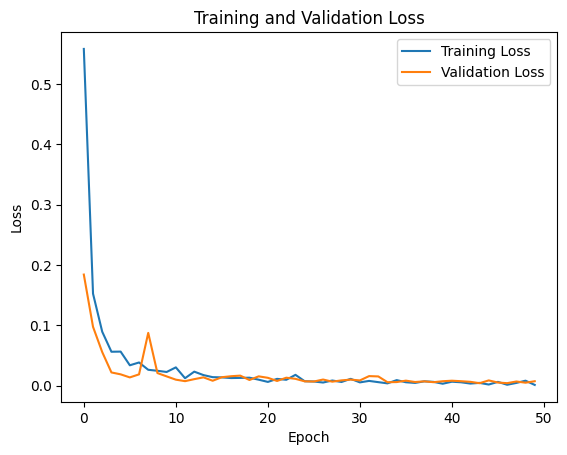

140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy: 0.9989
Precision: 0.9989
Recall: 0.9989
F1 Score: 0.9989
Sensitivity (Recall) for each class:
Class 0: 1.0000
Class 1: 1.0000
Class 2: 1.0000
Class 3: 1.0000
Class 4: 0.9886
Class 5: 1.0000
Class 6: 1.0000
Class 7: 1.0000
Class 8: 1.0000
Class 9: 1.0000
Class 10: 1.0000
Class 11: 1.0000
Class 12: 1.0000
Class 13: 1.0000
Class 14: 1.0000
Class 15: 1.0000
Class 16: 0.9892
Class 17: 1.0000
Class 18: 1.0000
Class 19: 1.0000
Class 20: 1.0000
Class 21: 1.0000
Class 22: 1.0000
Class 23: 1.0000
Class 24: 1.0000
Class 25: 0.9412
Class 26: 1.0000
Class 27: 1.0000
Class 28: 1.0000
Class 29: 1.0000
Class 30: 1.0000
Class 31: 1.0000
Class 32: 1.0000
Class 33: 1.0000
Specificity for each class:
Class 0: 1.0000
Class 1: 1.0000
Class 2: 1.0000
Class 3: 1.0000
Class 4: 1.0000
Class 5: 1.0000
Class 6: 1.0000
Class 7: 1.0000
Class 8: 0.9995
Class 9: 1.0000
Class 10: 1.0000
Class 11: 1.0000
Class 12: 1.0000
Class 13: 1.0000
Class 14: 1.0000
Class 15: 1.00

In [36]:
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.layers import BatchNormalization
# Plotting training and validation loss values
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Evaluate the model on test data
y_pred_proba = model.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Calculate precision, recall, and F1 score
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Calculate sensitivity (recall for each class)
sensitivity = np.diag(conf_matrix) / np.sum(conf_matrix, axis=1)
print("Sensitivity (Recall) for each class:")
for i in range(len(sensitivity)):
    print(f"Class {i}: {sensitivity[i]:.4f}")

# Calculate specificity for each class
specificity = []
for i in range(len(sensitivity)):
    specificity.append(np.sum(np.delete(np.delete(conf_matrix, i, axis=0), i, axis=1)) / np.sum(np.delete(conf_matrix, i, axis=0)))

print("Specificity for each class:")
for i in range(len(specificity)):
    print(f"Class {i}: {specificity[i]:.4f}")

Epoch 1/50
560/560 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - accuracy: 0.5981 - loss: 19.9057 - val_accuracy: 0.8000 - val_loss: 0.6294
Epoch 2/50
560/560 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - accuracy: 0.8284 - loss: 0.5953 - val_accuracy: 0.8607 - val_loss: 0.5134
Epoch 3/50
560/560 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - accuracy: 0.8681 - loss: 0.5127 - val_accuracy: 0.8888 - val_loss: 0.3675
Epoch 4/50
560/560 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - accuracy: 0.9124 - loss: 0.2766 - val_accuracy: 0.8931 - val_loss: 0.4133
Epoch 5/50
560/560 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - accuracy: 0.9019 - loss: 0.3907 - val_accuracy: 0.9158 - val_loss: 0.2636
Epoch 6/50
560/560 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - accuracy: 0.9416 - loss: 0.1896 - val_accuracy: 0.9536 - val_loss: 0.1661
Epoch 7/50
560/560 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - accuracy: 0.9540 - loss: 0.1500 - val_accuracy: 0.9362 - val_loss: 0.2472
Epoch 8/50
560/560 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - accuracy: 0.9303 - loss: 0.2830 -

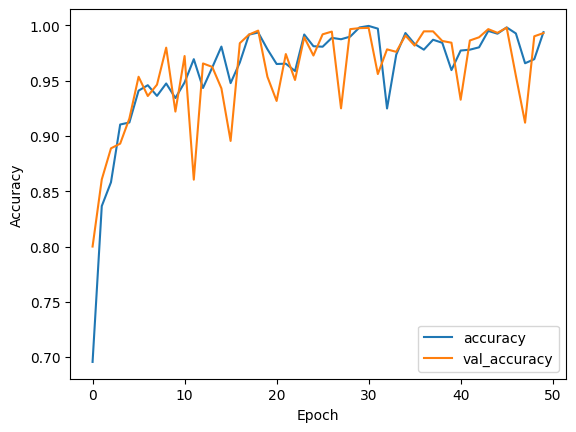

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Precision: 0.9895562821275914
Recall: 0.9889867841409692
F1 Score: 0.989062421966083


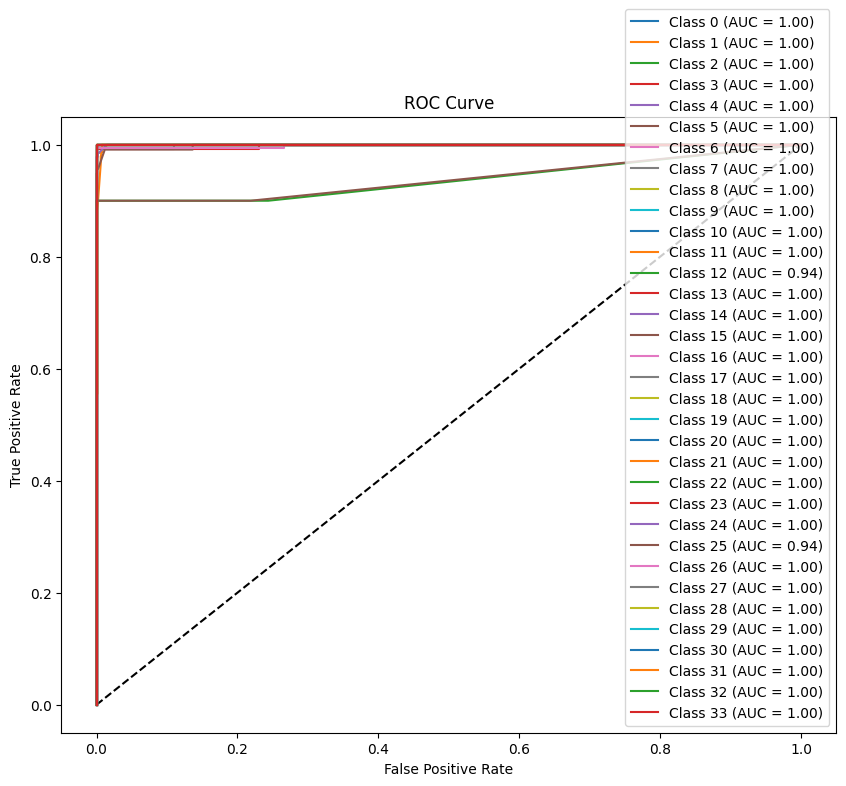

In [32]:
from sklearn.model_selection import train_test_split

# Assuming 'signals' contains the signal data and 'encoded_labels' are the numerical labels
X_train, X_test, y_train, y_test = train_test_split(augmented_signals, augmented_labels, test_size=0.2, random_state=42)

from tensorflow.keras import models, layers

model = models.Sequential()

# Convolutional layers
model.add(layers.Conv1D(64, kernel_size=3, activation='relu', input_shape=(2400,6)))
model.add(layers.MaxPooling1D(pool_size=2))
model.add(layers.Conv1D(128, kernel_size=3, activation='relu'))
model.add(layers.MaxPooling1D(pool_size=2))
model.add(layers.Conv1D(256, kernel_size=3, activation='relu'))
model.add(layers.MaxPooling1D(pool_size=2))

# Flatten layer to transition from convolutional layers to dense layers
model.add(layers.Flatten())

# Dense layers
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(units=34, activation='softmax'))  # Output layer

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test))

test_loss, test_acc = model.evaluate(signals, encoded_labels)

import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Making predictions
y_pred = model.predict(signals)

# Converting predictions to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculating precision, recall, and F1 score
precision = precision_score(encoded_labels, y_pred_classes, average='weighted')
recall = recall_score(encoded_labels, y_pred_classes, average='weighted')
f1 = f1_score(encoded_labels, y_pred_classes, average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Calculating ROC curve and AUC
n_classes = 34  # Number of classes
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(encoded_labels == i, y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotting ROC curve
plt.figure(figsize=(10, 8))
plt.plot([0, 1], [0, 1], 'k--')
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='Class {} (AUC = {:.2f})'.format(i, roc_auc[i]))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np

# Define the Generator
def build_generator(latent_dim, output_shape):
    model = models.Sequential()
    model.add(layers.Dense(256, input_dim=latent_dim))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dense(512))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dense(1024))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dense(np.prod(output_shape), activation='tanh'))
    model.add(layers.Reshape(output_shape))
    return model

# Define the Discriminator
def build_discriminator(input_shape):
    model = models.Sequential()
    model.add(layers.Flatten(input_shape=input_shape))
    model.add(layers.Dense(512))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dense(256))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

# Define the GAN
def build_gan(generator, discriminator):
    discriminator.trainable = False
    model = models.Sequential()
    model.add(generator)
    model.add(discriminator)
    return model

# Compile the Discriminator
def compile_discriminator(discriminator):
    discriminator.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Compile the GAN
def compile_gan(gan):
    gan.compile(loss='binary_crossentropy', optimizer='adam')

# Train the GAN
def train_gan(generator, discriminator, gan, signals, labels):
    epochs = 1000
    batch_size = 32
    half_batch = batch_size // 2
    signal_shape = signals.shape[1:]
    augmented_data = []
    # Lists to store loss values for plotting
    d_losses = []
    g_losses = []
    
    for epoch in range(epochs):
        # Select a random half batch of real data
        idx = np.random.randint(0, signals.shape[0], half_batch)
        real_signals = signals[idx]
        real_labels = labels[idx]

        # Generate a half batch of fake samples
        noise = np.random.normal(0, 1, (half_batch, 100))
        fake_signals = generator.predict(noise)
        fake_labels = np.zeros((half_batch,))

        # Train the discriminator
        d_loss_real = discriminator.train_on_batch(real_signals, real_labels)
        d_loss_fake = discriminator.train_on_batch(fake_signals, fake_labels)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Generate noise for the generator
        noise = np.random.normal(0, 1, (batch_size, 100))

        # Labels for the generator
        valid_labels = np.ones((batch_size,))

        # Train the generator
        g_loss = gan.train_on_batch(noise, valid_labels)
        
        # Store losses for plotting
        d_losses.append(d_loss[0])
        g_losses.append(g_loss)
        
        # Combine real and fake signals for training your model
        augmented_signals = np.concatenate([real_signals, fake_signals])
        augmented_labels = np.concatenate([real_labels, fake_labels])

        augmented_data.append((augmented_signals, augmented_labels))

        # Print progress
        if epoch % 100 == 0:
            print(f"Epoch {epoch}, D Loss: {d_loss[0]}, G Loss: {g_loss}")
        
    return augmented_data

    # Plot the loss curves
    plt.figure(figsize=(12, 6))
    plt.plot(range(epochs), d_losses, label='Discriminator Loss')
    plt.plot(range(epochs), g_losses, label='Generator Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('GAN Training Loss')
    plt.legend()
    plt.show()

    return augmented_data

# Example usage
latent_dim = 100
output_shape = signals.shape[1:]
generator = build_generator(latent_dim, output_shape)
discriminator = build_discriminator(output_shape)
gan = build_gan(generator, discriminator)

compile_discriminator(discriminator)
compile_gan(gan)

augmented_data = train_gan(generator, discriminator, gan, signals, encoded_labels)

In [ ]:
 # Plot the loss curves
def plotfigure():
    plt.figure(figsize=(12, 6))
    plt.plot(range(epochs), d_losses, label='Discriminator Loss')
    plt.plot(range(epochs), g_losses, label='Generator Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('GAN Training Loss')
    plt.legend()
    plt.show()
plotfigure()


In [ ]:
augmented_signals = np.concatenate([item[0] for item in augmented_data])
augmented_labels = np.concatenate([item[1] for item in augmented_data])

In [ ]:
augmented_signals.shape, augmented_labels.shape

In [ ]:
signal,label = augmented_signals, augmented_labels

In [ ]:
signal.shape,label.shape

In [ ]:
from sklearn.model_selection import train_test_split

# Assuming 'signals' contains the signal data and 'encoded_labels' are the numerical labels
X_train, X_test, y_train, y_test = train_test_split(augmented_signals, augmented_labels, test_size=0.2, random_state=42)

In [ ]:
from tensorflow.keras import models, layers

model = models.Sequential()

# Convolutional layers
model.add(layers.Conv1D(64, kernel_size=3, activation='relu', input_shape=(2400,6)))
model.add(layers.MaxPooling1D(pool_size=2))
model.add(layers.Conv1D(128, kernel_size=3, activation='relu'))
model.add(layers.MaxPooling1D(pool_size=2))
model.add(layers.Conv1D(256, kernel_size=3, activation='relu'))
model.add(layers.MaxPooling1D(pool_size=2))

# Flatten layer to transition from convolutional layers to dense layers
model.add(layers.Flatten())

# Dense layers
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(units=34, activation='softmax'))  # Output layer

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test))

In [ ]:
test_loss, test_acc = model.evaluate(signals, encoded_labels)

import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# Making predictions
y_pred = model.predict(signals)

# Converting predictions to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculating precision, recall, and F1 score
precision = precision_score(encoded_labels, y_pred_classes, average='weighted')
recall = recall_score(encoded_labels, y_pred_classes, average='weighted')
f1 = f1_score(encoded_labels, y_pred_classes, average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Calculating ROC curve and AUC
n_classes = 34  # Number of classes
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(encoded_labels == i, y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotting ROC curve
plt.figure(figsize=(10, 8))
plt.plot([0, 1], [0, 1], 'k--')
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='Class {} (AUC = {:.2f})'.format(i, roc_auc[i]))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
from tensorflow.keras import models

# Assuming you've trained your model and stored it in the 'model' variable

# Save the model with .h5 extension
model.save("my_model.h5")

# Load the model
loaded_model = models.load_model("my_model.h5")

# Now you can use the loaded_model for predictions


In [ ]:
# Making predictions
pred = loaded_model.predict(signals)

# Converting predictions to class labels
y_pred_classes = np.argmax(pred, axis=1)

# Calculating precision, recall, and F1 score
precision = precision_score(encoded_labels, y_pred_classes, average='weighted')
recall = recall_score(encoded_labels, y_pred_classes, average='weighted')
f1 = f1_score(encoded_labels, y_pred_classes, average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Calculating ROC curve and AUC
n_classes = 34  # Number of classes
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(encoded_labels == i, y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotting ROC curve
plt.figure(figsize=(10, 8))
plt.plot([0, 1], [0, 1], 'k--')
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='Class {} (AUC = {:.2f})'.format(i, roc_auc[i]))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()